In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
# import whenever 
import glob
import os
import pytz
from timezonefinder import TimezoneFinder

In [2]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

### Functions

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [4]:
# Function to plot data (no widget)
def hv_plot_data(dataset):
    # Define misc plotting variables
    datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
    # months='%b %Y %H:%M')

    plot = dataset.hvplot(
        width=1200,height=500,
        label='Fluxnet',
        xlabel='time',
        xformatter= datetimeformatter,
        yformatter='%.1e',
        ylabel = 'NEE (kg C m-2 s-1)',
        title = f'{site_ID} (Daily Averages)',
        legend='bottom',
        grid=True,
    ).opts(legend_position='bottom_right')
    return plot

In [5]:
# # Function to plot data (widget)
# def hv_plot_data_widget(dataset):
#     # Define misc plotting variables
#     datetimeformatter = DatetimeTickFormatter(
#     hours='%H:%M',
#     days='%m/%d %H:%M',
#     months='%b %Y',
#     )
#     # months='%b %Y %H:%M')
    
#     plot = dataset.hvplot(
#         kind='line',
#         width=1300, height=400,
#         groupby=['time.year'],
#         # groupby=['time.year', 'time.month'],
#         widget_location='bottom',
#         xformatter= datetimeformatter,
#         yformatter='%.1e',
#         ylabel = 'NEE (kg C m-2 s-1)',
#         title = f'{site_ID} (Daily Averages)',
#         legend='bottom',
#         grid=True,
#     )    
#     return plot

In [6]:
# Function to obtain location data
def get_loc_data(site_ID):
    ## Fluxnet Data 
    # Import selected site daily subset data
    timedelta = 'DD'
    
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
    

    filepath = 'ameriflux-data/'
    sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects    
    fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
    fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

    # Convert units
    # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
    fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    
    # Mask bad QC values
    fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'].mask(fluxnet_sel_simple['NEE_VUT_REF_QC'] < 1, np.nan)
    
    # Import MiCASA from data-extract.py
    dir = 'output'
    filename = f'{site_ID}_micasa_{timedelta}.csv'
    path = os.path.join(dir, filename)
    micasa_ds = pd.read_csv(path,index_col=0)
    micasa_ds.index = pd.to_datetime(micasa_ds.index)
    
    # Append together
    plot_ds = micasa_ds.merge(fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'],left_index=True, right_index=True)
    return plot_ds

### Import data

In [7]:
timedelta = 'DD'

In [8]:
# Import site metadata csv
filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
# fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

In [13]:
# Example sites of varying geography
site_list = ['US-A32', 'US-Bar', 'US-RGB', 'US-xJE', 'US-SRC']
sites_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'].isin(site_list)]
# sites_meta

### Plot selected sites

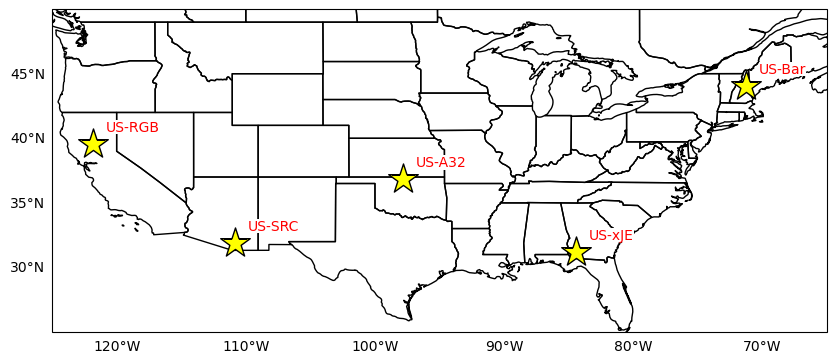

In [14]:
# Plot sites
proj=ccrs.PlateCarree()

# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(10,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)

for site_ID in site_list:
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3)
    ax.annotate(site_ID, (site_lon + 1,site_lat+1),
                color='red',
                bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                         )
                         
               )

gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [15]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

### Testing QC values

In [ ]:
# Test site
site_ID =  'US-A32'

In [ ]:
#import fluxnet
site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')

fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + convert to datetime objects    
fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

# Convert units
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple.copy()
fluxnet_sel_final['NEE_VUT_REF'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'

In [ ]:
# Import micasa
dir = 'output'
filename = f'{site_ID}_micasa_{timedelta}.csv'
path = os.path.join(dir, filename)
micasa_ds = pd.read_csv(path,index_col=0)
micasa_ds.index = pd.to_datetime(micasa_ds.index)
# micasa_ds

In [ ]:
# Quality flag for NEE_VUT_REF: fraction between 0-1, indicating percentage of measured and good quality gapfill data
# Note that this is different from the quality flag for the HH data
fluxnet_sel_final

In [ ]:
fluxnet_sel_final.hvplot(kind='scatter',
                         x='TIMESTAMP',y='NEE_VUT_REF', c='NEE_VUT_REF_QC',
                         cmap = 'bmy', 
                         clabel='% of measured and good quality data',
                        # groupby=['TIMESTAMP.year'],
                        # widget_location='bottom',
                         width=1000, height=400,
                         title='Raw FluxNET Daily',
                         xlabel='time',
                        ylabel = 'NEE (kg C m-2 s-1)',
                         
                     )

In [ ]:
# Set all values not 1 as NaN
fluxnet_sel_QC0 = fluxnet_sel_final.copy()
fluxnet_sel_QC0['NEE_VUT_REF'] = fluxnet_sel_QC0['NEE_VUT_REF'].mask(fluxnet_sel_QC0['NEE_VUT_REF_QC'] < 1, np.nan)
fluxnet_sel_QC0

In [ ]:
plot1 = fluxnet_sel_QC0['NEE_VUT_REF'].hvplot(
                        c='red',
                        # groupby=['TIMESTAMP.year'],
                        # widget_location='bottom',
                       width=1200,height=500,
                       label='Fluxnet',
                        xlabel='time',
                        ylabel = 'NEE (kg C m-2 s-1)',
)

In [ ]:
plot2 = micasa_ds.hvplot(label='MiCASA',
                         # groupby=['time.year']
                         c='skyblue'
                        )

In [ ]:
plot1 * plot2 

# US-A32

In [16]:
site_ID =  'US-A32'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
133,US-A32,ARM-SGP Medford hay pasture,"Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.","Humid Subtropical: mild with no dry season, hot summer",335.0,"2015, 2016, 2017"


In [17]:
A32_data = get_loc_data(site_ID)

In [18]:
hv_plot_data(A32_data)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [ ]:
# Example sites of varying geography
site_list = ['US-A32', 'US-Bar', 'US-RGB', 'US-xJE', 'US-SRC']
sites_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'].isin(site_list)]
# sites_meta

# US-RGB

In [19]:
site_ID =  'US-RGB'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
477,US-RGB,Butte County Rice Farm,"Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.","Mediterranean: mild with dry, hot summer",33.0,2021


In [20]:
RGB_data = get_loc_data(site_ID)

In [21]:
hv_plot_data(RGB_data)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

# US-Bar

In [22]:
site_ID =  'US-Bar'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
157,US-Bar,Bartlett Experimental Forest,Deciduous Broadleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.,Warm Summer Continental: significant precipitation in all seasons,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021"


In [23]:
Bar_data = get_loc_data(site_ID)

In [24]:
hv_plot_data(Bar_data)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

# US-xJE

In [25]:
site_ID =  'US-xJE'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
640,US-xJE,NEON Jones Ecological Research Center (JERC),Evergreen Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.,"Humid Subtropical: mild with no dry season, hot summer",44.0,"2017, 2018, 2019, 2020, 2021"


In [26]:
xJE_data = get_loc_data(site_ID)

In [27]:
hv_plot_data(xJE_data)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

# US-SRC

In [28]:
site_ID =  'US-SRC'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
530,US-SRC,Santa Rita Creosote,Open Shrublands: Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.,Desert: warm winter,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014"


In [29]:
SRC_data = get_loc_data(site_ID)

In [30]:
hv_plot_data(SRC_data)

:NdOverlay   [Variable]
   :Curve   [time]   (value)